## How transferable are features in deep neural networks??? - Oded Ben Chetrit
I this project I will implement the experiment described in the paper:

"How transferable are features in deep neural networks" 

https://arxiv.org/abs/1411.1792

In [1]:
# imports: 
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import time
import torch.optim as optim
from PIL import Image
from tqdm import tqdm
import torch.nn.functional as F
from torchvision import datasets
from torch import nn
import seaborn as sns
import copy
import pickle
# for cases where the kernel shutsdown with imshow:
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

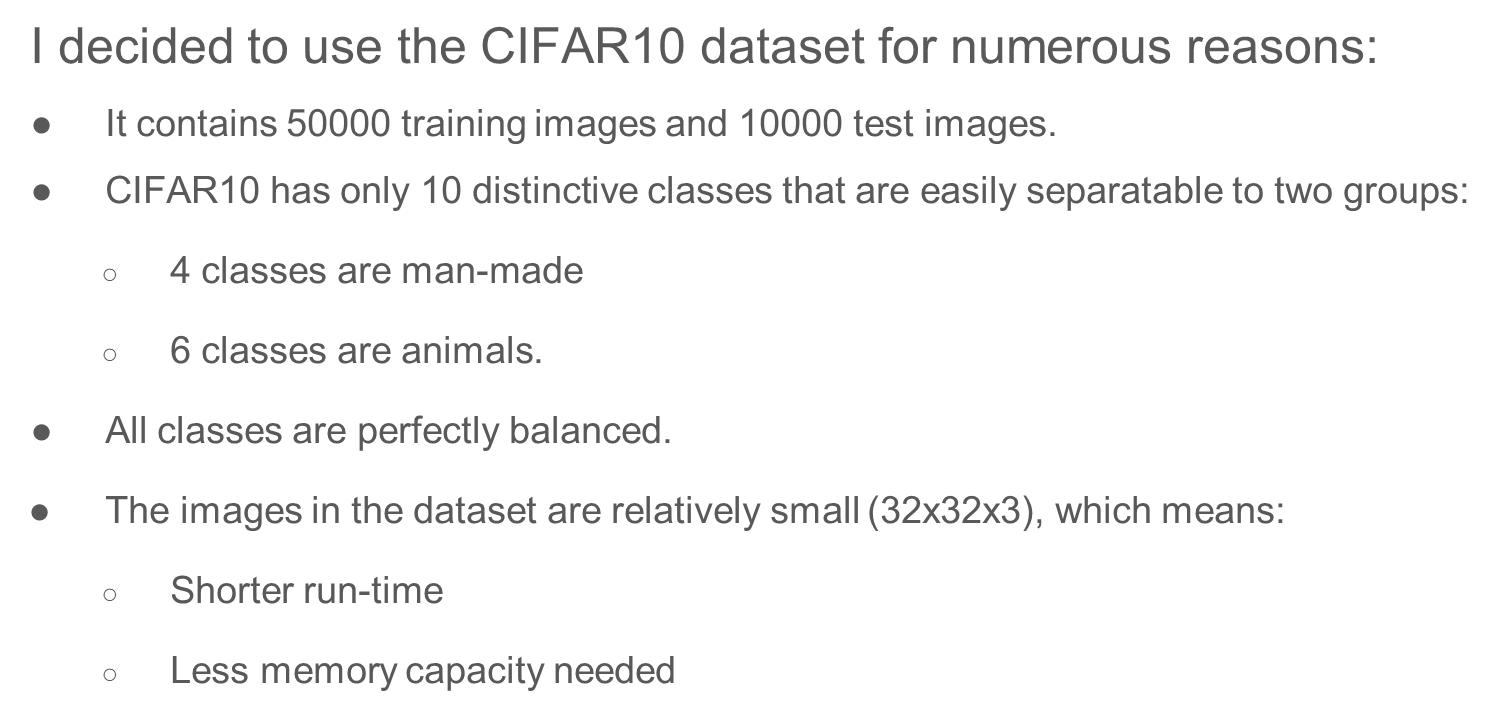

In [2]:
transform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

# If open in colab - downlaod = True : 
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


We can take those two groups and mix them into two sub-datasets that would have a balanced combination of 2 man made classes and 3 animal classes of images, just like it’s been done in the experiment of the research. 

Class A = ('plane', 'car', 'bird', 'cat', 'deer')
Class B = ('dog', 'frog', 'horse', 'ship', 'truck’)


In [3]:
# Create a simple dataset class for the splitted datasets:
class Dataset(Dataset):
    def __init__(self, images, targets, transform = False):
        self.images = images
        self.targets = self._map_index(targets)
        self.transform = transform 
    
    def _map_index(self, targets):
        return (np.array(targets) - min(np.unique(targets))).tolist()

    # A function that reduces the data size for debuging applications. 
    def small_dataset(self):
        self.images = self.images[0:100]
        self.targets = self.targets[0:100]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.targets[idx]
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def get_images_labels(self):
        return self.images, self.targets

def append_in_dataset(dataset, mask, transform, small_data = False):
    images = dataset.data[mask]
    labels = np.array(dataset.targets)[mask].tolist()
    dataset = Dataset(images, labels, transform)
    if small_data: 
        dataset.small_dataset()
    return dataset

# Define A/B datasets by class groups: 
def split_to_classes(dataset, classes, transform = False, small_data = False):
    N = len(dataset)
    mask = np.array([dataset.targets[i] in classes for i in range(N)])
    dataset = append_in_dataset(dataset, mask, transform, small_data)
    return dataset

In [4]:
# Define classes:  
class_A = [*range(0,5)]
class_B = [*range(5,10)]

# Define datasets:
train_A = split_to_classes(trainset, class_A, transform = transform, small_data = False)
train_B = split_to_classes(trainset, class_B, transform = transform, small_data = False)
test_A = split_to_classes(testset, class_A, transform = transform, small_data = False)
test_B = split_to_classes(testset, class_B, transform = transform, small_data = False)

# Define dataloaders:
train_A_dataloader = DataLoader(train_A, batch_size = batch_size, shuffle=True)
test_A_dataloader = DataLoader(test_A, batch_size = batch_size, shuffle=True)
train_B_dataloader = DataLoader(train_B, batch_size = batch_size, shuffle=True)
test_B_dataloader = DataLoader(test_B, batch_size = batch_size, shuffle=True)

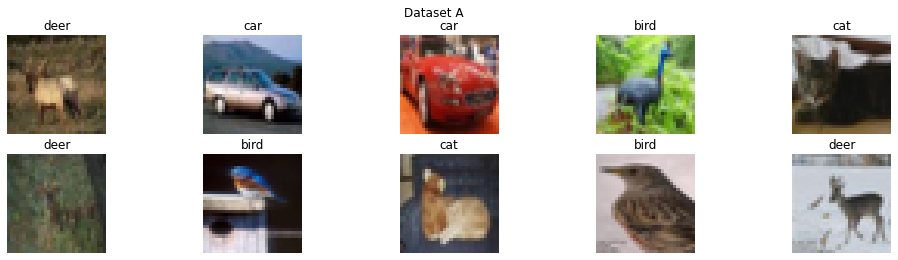

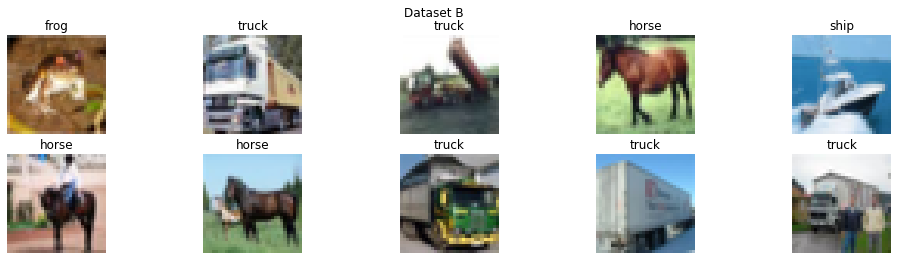

In [5]:
# Image display function: 
def imshow(dataset, idx, classes):
    target = dataset.__getitem__(idx)[1]
    img = dataset.__getitem__(idx)[0]
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    t_img = np.transpose(img, (1, 2, 0))
    plt.imshow(t_img)
    plt.title(classes[target])
    plt.axis('off')
    
class_A = ('plane', 'car', 'bird', 'cat', 'deer')
class_B = ('dog', 'frog', 'horse', 'ship', 'truck')

plt.figure(figsize = (17,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    imshow(train_A,i,class_A)
plt.suptitle('Dataset A')
plt.show()

plt.figure(figsize = (17,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    imshow(train_B,i,class_B)
plt.suptitle('Dataset B')
plt.show()

In [6]:
# Define metrics, and a class wrapper for the model: 
@torch.no_grad()
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        accu = accuracy(out,labels)
        return loss,accu
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'Loss': loss.detach(), 'Accuracy': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['Loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['Accuracy'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'Loss': epoch_loss.item(), 'Accuracy': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch :",epoch + 1)
        print(f'Train Accuracy:{result["train_accuracy"]*100:.2f}% Validation Accuracy:{result["Accuracy"]*100:.2f}%')
        print(f'Train Loss:{result["train_loss"]:.4f} Validation Loss:{result["Loss"]:.4f}')

In [7]:
# Define model 
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 32 x 16 x 16

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 8 x 8
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 4 x 4

            nn.Flatten(), 
            nn.Linear(128*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 5))
        
        
    def forward(self, xb):
        return self.network(xb)

In [14]:
# functions to train and evaluate the model: 
@torch.no_grad()
def evaluate(model, data_loader):
    model.eval()
    outputs = [model.validation_step([batch[0].to(device), batch[1].to(device)]) for batch in data_loader]
    return model.validation_epoch_end(outputs)

def fit(model, train_loader, val_loader, epochs=1, learning_rate=0.001):
    model = model.to(device)
    best_valid = None
    history = []
    optimizer = torch.optim.Adam(model.parameters(), learning_rate,weight_decay=0.0005)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        train_accuracy = []
        for batch in tqdm(train_loader):
            batch = [batch[0].to(device), batch[1].to(device)]
            loss,accu = model.training_step(batch)
            train_losses.append(loss)
            train_accuracy.append(accu)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_accuracy'] = torch.stack(train_accuracy).mean().item()
        model.epoch_end(epoch, result)
        if(best_valid == None or best_valid<result['Accuracy']):

            best_valid=result['Accuracy']
        history.append(result)
    return model, history

In [16]:
# Train Base models A and B: 
initial_model = Cifar10CnnModel()
epochs = 4

Base_A = copy.deepcopy(initial_model)
Base_A, results_Base_A = fit(Base_A, train_A_dataloader, test_A_dataloader, epochs=epochs)

Base_B = copy.deepcopy(initial_model)
Base_B, results_Base_B = fit(Base_B, train_B_dataloader, test_B_dataloader, epochs=epochs)

with open('Base.pkl', 'wb') as fid:
     pickle.dump([Base_A, results_Base_A, Base_B, results_Base_B], fid)

In [17]:
# The layer number names as given in 'initial_model.state_dict()':
layers_num = [0,2,5,7,10,12,16,18]
N = len(layers_num)

# Define dicts of parameters for the initalized model, Base A and Base B:
initial_model_dict = dict(initial_model.state_dict())
Base_A_dict = dict(Base_A.state_dict())
Base_B_dict = dict(Base_B.state_dict())

# A Function that given a dataset, an initialized model and a pre-trained model -> train a network for each iterated 
# layer, by transfering the n initial layers from 'transfered_model' and the rest of the layers are initialized like 
# 'initial_model'. There is also a flag that defines if the transfered layers are to be trained or not. 

# The output of the function is a result dict that contain each model in the itaration its results.
def experiment(transfered_model,
               initial_model=initial_model,
               train_dataloader=train_B_dataloader,
               test_dataloader=test_B_dataloader,
               freeze=True, epochs=4):
    
    transfer_layers = []
    
    # obtain transfer model parameters in a dict:
    transfered_model_dict = dict(transfered_model.state_dict())
    results_dict = dict()
    for i, j in tqdm(enumerate(layers_num)):
        
        # The trained model is a copy of the initialized model.
        model = copy.deepcopy(initial_model)
        
        #Store the initial parameters in a dict:
        params = initial_model.state_dict()
        model_dict = dict(params)

        # get the next names of parameters to transfer and append them in a list: 
        transfer_layer = [l for l in params.keys() if 'network.'+str(j)+'.' in l]
        transfer_layers += transfer_layer
        print(f'transfered layer: 1:{i}\n transfer_layers:\n{transfer_layers}')
        
        # Transfer layers from 'transfered_model' to 'model' -> from the first layer to the n'th.  
        for layer in transfer_layers:
            model_dict[layer] = transfered_model_dict[layer]
        model.load_state_dict(model_dict)
        
        # If transfered parameters are to be freezed - 'set requires_grad = False':
        if freeze: 
            for layer, param in model.named_parameters():
                if layer in transfer_layers:
                    param.requires_grad = False
        
        # fit the model and store accuracy and loss results:        
        model, results = fit(model, train_dataloader, test_dataloader, epochs=epochs)
        results_dict[str(i+1)] = [model, results]
    
    return results_dict

In [ ]:
# Experiment setup: 

# Network 1: BnB - A selffer network: the first n layers are copied from baseB and frozen. The rest higher
# layers are initialized randomly and trained on dataset B. This network is a control for the
# next transfer network.

# Network 2: AnB - A transfer network - the first n layers are copied from baseA and frozen. The rest higher
# layers are initialized randomly and trained toward dataset B. 

# Network 3: BnB+ -  A selffer network - just like BnB, but where all layers learn.

# Network 4: AnB+ -  A transfer network - just like AnB, but where all layers learn.

# Set setup: 
experiment_dict = {'BnB':
                   {'transfered_model': Base_B,'freeze': True},

                    'AnB':
                   {'transfered_model': Base_A,'freeze': True},
                   
                   'BnB_plus':
                   {'transfered_model': Base_B,'freeze': False},

                    'AnB_plus':
                   {'transfered_model': Base_A,'freeze': False}
                  }

experiment_res = {}
experiment_acc = {}

# Run experiment for the different setting to compute Networks 1-4 (each Network actually contains n different networks.) 
for exp in experiment_dict.keys():  
    experiment_res[exp] = experiment(**experiment_dict[exp])
     
    # Save result dict for each experiment with its own name:  
    with open(exp+'.pkl', 'wb') as fid:
         pickle.dump(experiment_res[exp], fid)
    # get the final validation accuracy for each network (total n networks) for each experiment:
    acc = []
    for i in range(N):
        acc.append(experiment_res[exp][str(i+1)][1][epochs-1]['Accuracy'])
    experiment_acc[exp] = acc
# Add the accuracy of Base_B to the dict - for plotting purposes only: 
experiment_acc['Base_B'] = results_Base_B[epochs-1]['Accuracy']

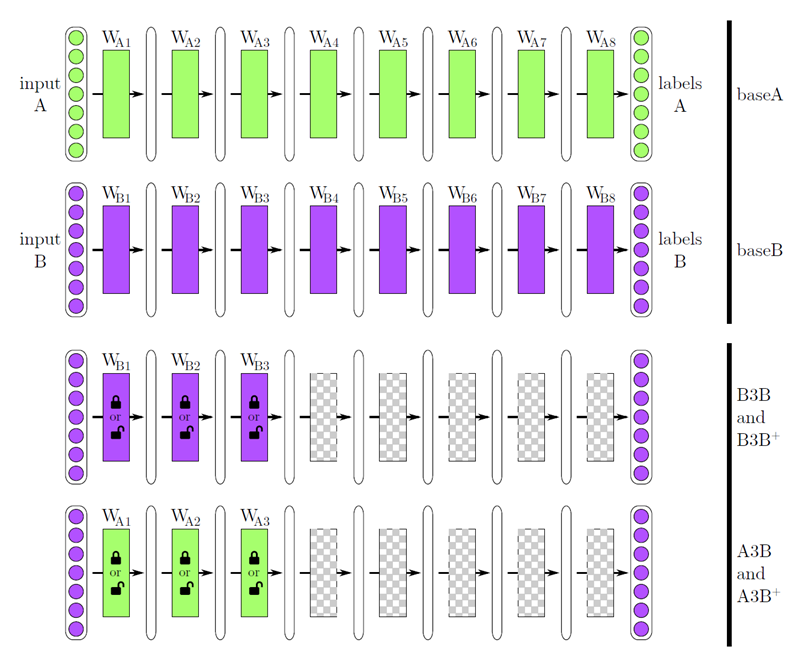


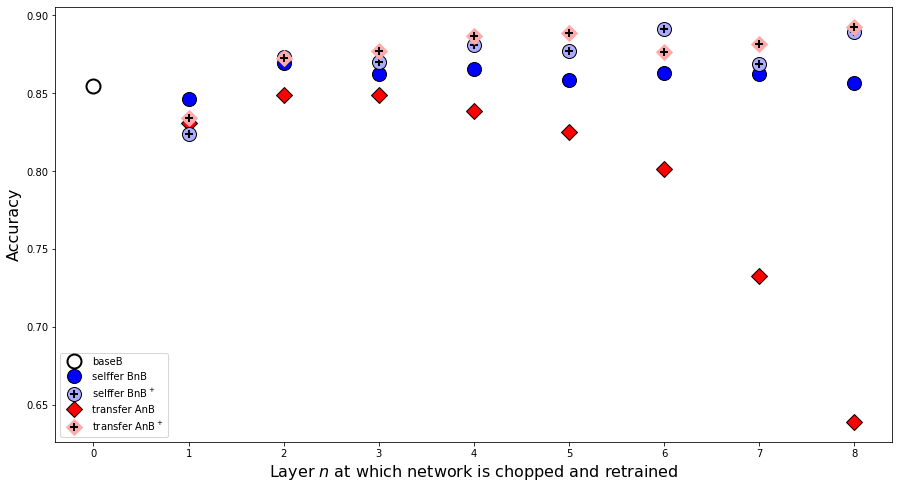

In [19]:
# Plot results: 
plt.figure(figsize = (15,8))
msize = 14
msized = 12
msizep = 8

hh = {}
hh['k'],=plt.plot(0,experiment_acc['Base_B'],'o', color = 'w', mec = 'k', mew=2, markersize=msize)
         
vals = experiment_acc['BnB']
hh['b'],=plt.plot(np.arange(1,9), vals, 'o', color = 'b',mec = 'k', markersize=msize)

vals = experiment_acc['AnB']
hh['r'],=plt.plot(np.arange(1,9), vals, 'D', color = 'r',mec = 'k', markersize=msized)

vals = experiment_acc['BnB_plus']
hh['bft1'],=plt.plot(np.arange(1,9), vals, 'o', color = '#aaaaff',mec = 'k', markersize=msize)
hh['bft2'],=plt.plot(np.arange(1,9), vals, '+', color = 'k',mec = 'k', mew=2, markersize=msizep)

vals = experiment_acc['AnB_plus']
hh['rft1'],=plt.plot(np.arange(1,9), vals, 'D', color = '#ffaaaa', markersize=msized)
hh['rft2'],=plt.plot(np.arange(1,9), vals, ls='', marker='+', color = 'k', mew=2, markersize=msizep)

plt.legend([hh['k'], hh['b'], (hh['bft1'],hh['bft2']), hh['r'], (hh['rft1'],hh['rft2'])],
       ['baseB', 'selffer BnB', 'selffer BnB$^+$', 'transfer AnB', 'transfer AnB$^+$'], numpoints=1)

plt.ylabel('Accuracy',fontsize=16)
plt.xlabel('Layer $n$ at which network is chopped and retrained', fontsize=16)
plt.show()

- The results of the experiment turned very similar to the experiment made on the research paper.

- As we can see, as we use more layers, the conv-network have hard time to generalize its features, and therefore its harder for it to be used as just a pretrained body for a head with different classes from what the conv-network was trained for.

- The big advantage of this method, is when there is a finetuning stage. 

- There we see the whole finetuned network getting very good results, which gets better as we chop the network in a later layer.

- Because the two sub datasets are balanced, we can easily see the results are very symmetric between AnB and BnB transfers.

- The only drop in accuracy we can see happens just a bit before the final layer, and it fits the co-adaptation problem described in the research paper as well.
